# Análise Exploratória dos dados

## Resumo
Este notebook foi destinado para análise exploratória do dataset disponibilizado pelo Hospital Sírio-Libanês no [kaggle](https://www.kaggle.com/S%C3%ADrio-Libanes/covid19). A análise teve como objetivo, primeiramente, entender o dataset, pré-processar os dados de forma que seja possível usá-los como valores entrada a um algoritmo de Machine Learning, e após isso estudar proporções, correlações e variâncias com o objetivo de encontrar os possíveis caminhos ao se selecionar apenas os dados mais úteis para o problema. Por fim, os dados pré-processados foram salvos na pasta [dados_preprocessados](), a fim de serem utilizados no notebook de [Predicoes]().

## Pré-Processamento 
O pré-processamento dos dados em machine learning é um dos passos fundamentais em um projeto que se propõe a realizar predições de Machine Learning, a famosa frase "garbage in, garbage out" atribuída ao técnico da IBM George Fuechsel que significa, "entra lixo, sai lixo", demonstra muito bem o porque essa fase é tão importante, se não prepararmos os nossos dados da maneira correta os resultados podem ser mentirosos, ou não ter utilidade alguma no final, e, muitas vezes podem passar despercebidos, por esta razão essas é uma das fases mais importantes na hora de manipular dados.<br>

Uma boa parte desse processo já foi realizado pela equipe do Hospital Sírio-Libanês, de acordo com o hospital esse conjunto de dados contém dados anonimizados coletados no Hospital Sírio-Libanês, localizados em São Paulo e em Brasília. Toda a anonimização desses dados seguiu as melhores práticas e recomendações internacionais, e os dados passaram por um processo de limpeza e normalização por coluna de acordo com os valores máximos e mínimos de forma que todos os valores estivessem no intervalo entre -1 e 1.<br>
## Estrutura dos dados
### Chave primária<br>
A coluna 'PATIENT_VISIT_IDENTIFIER' é composta por números inteiros e é responsável por identificar cada paciente diferente.<br>
### Variável a ser prevista<br>
A variável a ser prevista é a coluna 'ICU', que, no conjunto de dados original, indica se o paciente correspondente estava ou não na UTI naquele momento.<br>
### Janela de tempo<br>
De acordo com o Hospital a variável 'WINDOW' diz respeito à janela de tempo onde as medições foram realizadas, ela está organizada da seguinte maneira:<br>

|Janela | Descrição|
|:-------------|:----------:|
|0-2 | Entre 0 até 2 horas a partir da admissão do paciente 
|2-4 | Entre 2 até 4 horas a partir da admissão do paciente 
|4-6 | Entre 4 até 6 horas a partir da admissão do paciente 
|6-12| Entre 6 até 12 horas a partir da admissão do paciente 
|Above-12| Mais de 12 horas horas a partir da admissão do paciente 

### Demais variáveis
As demais colunas do conjunto conjunto de dados trazem informações sobre:
* Informações demográficas do paciente (03)
* Grupos de doenças previamente identificadas pelos pacientes (09)
* Resultados de exames de sangue (36)
* Sinais vitais (06)<br>

No total são 54 variáveis, correspondente às médias, medianas, máximos, minímos, diferenças e diferenças relativas dos dados do paciente.<br>

### Dados faltantes<br>

Um dos maiores desafios ao se analisar dados médicos é a variação entre diferentes tipos de medições, por exemplo, os sinais vitais são coletados com mais frequência (geralmente de hora em hora) do que os laboratórios de sangue (geralmente diariamente).Fato esse acaba causando diversos dados faltantes uma vez que estamos analisando todos esses dados juntos em um mesmo conjunto.<br>

De acordo com o Hospital, para solucionar o problema dos dados faltantes, é razoável supor que um paciente que não tem uma medição registrada em uma janela de tempo esteja clinicamente estável, podendo apresentar sinais vitais e exames de sangue semelhantes às janelas vizinhas. Portanto, pode-se preencher os valores ausentes usando a entrada seguinte ou anterior.<br>  
### Problema a ser resolvido<br>
A identificação precoce dos pacientes que desenvolverão um curso adverso da doença (e precisam de cuidados intensivos) é a chave para um tratamento adequado (salvar vidas) e para gerenciar leitos e recursos. Um bom modelo usando apenas o primeiro (0-2) provavelmente será mais clinicamente relevante, por esta razão os dados serão agrupados de forma reorganizados a fim de agrupar os dados médicos por paciente e apenas as informações da primeira janela serão utilizadas para identificar se um paciente precisou de internação em qualquer uma das janelas.

### Escopo do projeto
- Importação dos pacotes :<br> 
- Importação das funções locais :
- Leitura dos dados brutos
- Pré-processamento
- Análise das variáveis demográficas
- Análise das demais variáveis categóricas
- Análise das variáveis numéricas

In [10]:
# Definindo a semente de números aleatórios
SEED = 64541

## Importação dos pacotes

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import re
import warnings

In [2]:
warnings.filterwarnings('ignore')
sns.set_style('darkgrid')

## Importação das funções locais

In [3]:
import os
os.chdir("../funcoes")
from feature import compute_chi2, compute_high_corr, binary_features
from my_plot import labs, annot_bar
from preprocessing import fill_table, select_window
os.chdir("../notebooks")

In [ ]:
!pip uninstall fit

In [35]:
binary_features??

Signature: binary_features(data: pandas.core.frame.DataFrame)
Source:   
def binary_features(data:pd.DataFrame):
    '''
    Função que recebe um DataFrame do pandas e verifica quais as colunas binárias.Realiza essa verificação consultando quantos valores únicos a coluna possui
    e tenta transformar-la em números inteiros
    
    Parâmetros:
    -----------
    data : DataFrame do pandas que será 
    
    Retorno:
    --------
    features : colunas binárias do dataframe
    '''
    #Criando a lista vazia para armazenar as colunas binarias
    features = []
    
    #Percorrendo as colunas do dataframe
    for feature in data.columns:
        
        #Verificando se a coluna possui apenas 2 valores únicos
        if len(data[feature].unique()) == 2:
            
            if max(data[feature])==1 and min(data[feature])==0:
                #Salvando o nome da coluna na lista
                features.append(feature)
                
    return features
File:      c:\users\pedro\do

In [14]:
compute_chi2??

Signature: compute_chi2(X: pandas.core.frame.DataFrame, y: pandas.core.series.Series)
Source:   
def compute_chi2(X:pd.DataFrame, y:pd.Series):
    '''
    Recebe um dataframe do pandas com as colunas variáveis preditoras e uma series do pandas da variável de reposta e calcula através da função sklearn.model_selection.chi2 
    os p valores para cada coluna da hipótese nula de que as variáveis preditoras são independentes da variável de reposta
    
    Parâmetros:
    -----------
    X : dataframe com as variáveis preditoras, tipo : pd.DataFrame, OBS: pode conter apenas uma coluna mas precisa ser do tipo pd.DataFrame
    y : series do pandas da variável de resposta, tipo : pd.Series
    
    Retorno:
    -------
    p_values : dicionário contendo os p valores de cada coluna analisada
    '''
    #Criando o dicionário vazio para armazenar os p valores
    p_values = {}
        
    #Calulando as estatísticas de teste e p valores através da função sklearn.chi2
    chi2 = chi2(X, y)
    

In [15]:
compute_high_corr??

Signature:
compute_high_corr(
    data: pandas.core.frame.DataFrame,
    threshold: float = 0.95,
)
Source:   
def compute_high_corr(data:pd.DataFrame, threshold:float=0.95):
    '''
    Função que recebe um dataframe do pandas, calcula a matriz de correlação, seleciona o triângulo superior da matriz e percorre as colunas verificando quais colunas apresentam
    uma correlação maior que o valor limite passado, em relação às linhas, que nesse caso representam as colunas anteriores. 
    
    Parâmetros:
    -----------
    data : DataFrame do pandas com as variáveis a serem analisadas
    threshold : valor limite da correlação entre duas variáveis, ou seja, se duas colunas que possuem uma correlação absoluta maior que esse valor uma das duas será eliminada,
                    tipo : str, padrão : 0.95
    
    '''
    #Calculando a matriz de correlação absoluta
    matrix_corr = data.corr().abs()
    
    #Filtrando apenas a matriz superior
    matrix_corr_upper = matrix_corr.where(np.

In [16]:
labs??

Signature:
labs(
    ax,
    title: str = '',
    subtitle: str = '',
    xlabel: str = '',
    ylabel: str = '',
)
Source:   
def labs(ax, title:str='', subtitle:str='', xlabel:str='', ylabel:str=''):
    '''
    Função que plota as informações adicionais dos gráficos, título, subtítulo, rótulos, labels, fontes
    
    Parâmetros:
    ----------
    ax : eixo a ser plotado o gráfico, se nenhum for passado será criado automaticamnete, tipo : matplotlib.axes
    title : título do gráfico, tipo : str, padrão : ''
    subtitle : subtítulo do gráfico, tipo : str, padrão : ''
    xlabel : rótulo do eixo x, tipo : str, padrão : ''
    ylabel : rótulo do eixo y, tipo : str, padrão : ''
    '''
    #Seta o eixo passado
    plt.sca(ax)
    #Se o subtítulo for passado adiciona uma nova linha
    if subtitle != '':
        title = title + '\n' 
    #Plota o título
    plt.title(title, fontsize=25, loc='left')
    #Plota o subtítulo
    plt.text(0,1.02, subtitle, color='gray', transform=ax.transA

In [26]:
annot_bar??

Signature: annot_bar(ax, prop=True)
Source:   
def annot_bar(ax, prop=True):
    '''
    Realiza anotações em cima das barras em um gráfico de barras 
    
    Parâmetros:
    -----------
    ax : ax : eixo do matplotlib onde será plotada as linhas, tipo : matplotlib.axes
    prop : indicando se os valores serão representados como porcentagens ou não, tipo : bool, padrão : True
    
    OBS : precisa ser chamada após o gráfico de barras
    '''
    #Salva as informações das barras que estão no gráfico
    rects = ax.patches
    
    #Verifica se é do tipo porcentagem
    if prop:
        str_symbol = '%'
        mult_value = 100
    else:
        str_symbol = ''
        mult_value = 1
    
    #Anota no gráfico em cima de cada barra os valores 
    for rect in rects:
        height = rect.get_height()
        ax.text(rect.get_x() + rect.get_width() / 2, height, str(round(height * mult_value,2)) + str_symbol, color='black', ha='center', va='bottom', fontsize=15)
File:      c:\users\pedr

In [25]:
fill_table??

Signature: fill_table(rows)
Source:   
def fill_table(rows):
    '''
    Função que recebe as linhas correspondentes a apenas um paciente e preenche os valores nulos das colunas contínuas com dados de outras janelas
    
    Parâmetros:
    -----------
    rows : as linhas correspondentes ao mesmo paciente
    
    Retorno:
    --------
    Retorna as linhas preenchidas
    '''
    #Aplicando os métodos de 'bfill' e 'ffill' nas colunas contínuas 
    rows[rows.select_dtypes('float64').columns] = rows[rows.select_dtypes('float64').columns].fillna(method='bfill').fillna(method='ffill')
    return rows
File:      c:\users\pedro\documents\alura\projeto_final_bootcamp\funcoes\preprocessing.py
Type:      function


In [24]:
select_window??

Signature: select_window(rows, window='0-2', target_variable='ICU')
Source:   
def select_window(rows, window='0-2', target_variable='ICU'):
    '''
    Função que seleciona a janela correspondente e verifica se em algum momento o paciente foi para UTI, com isso modifica a coluna dependente para se em qualquer janela de tempo esse 
    paciente foi para UTI
    
    Parâmetros:
    -----------
    rows : as linhas correspondentes ao mesmo paciente
    window : coluna correspondente à janela que será mantida, padrão : '0-2'
    target_variable : nome da variável dependente, padrão : 'ICU'
    
    Retono:
    -------
    Retorna o conjunto de dados preenchido
    '''
    #Verificando se o paciente foi para UTI em qualquer momento
    if(numpy_any(rows[target_variable])):
        rows.loc[rows["WINDOW"]==window, target_variable] = 1
    #Retornando apenas os dados da janela especificada
    return rows.loc[rows["WINDOW"] == window]
File:      c:\users\pedro\documents\alura\projeto_final_

## Leitura dos dados brutos

In [15]:
# Lendo os dados brutos 
df = pd.read_excel('../dados/dados_brutos/Kaggle_Sirio_Libanes_ICU_Prediction.xlsx')

## Pré-Processamento

Para entender melhor o dataset vou ollhar as primeiras linhas.

In [16]:
df.head()

,PATIENT_VISIT_IDENTIFIER,AGE_ABOVE65,AGE_PERCENTIL,GENDER,DISEASE GROUPING 1,DISEASE GROUPING 2,DISEASE GROUPING 3,DISEASE GROUPING 4,DISEASE GROUPING 5,DISEASE GROUPING 6,...,TEMPERATURE_DIFF,OXYGEN_SATURATION_DIFF,BLOODPRESSURE_DIASTOLIC_DIFF_REL,BLOODPRESSURE_SISTOLIC_DIFF_REL,HEART_RATE_DIFF_REL,RESPIRATORY_RATE_DIFF_REL,TEMPERATURE_DIFF_REL,OXYGEN_SATURATION_DIFF_REL,WINDOW,ICU
0,0,1,60th,0,0.0,0.0,0.0,0.0,1.0,1.0,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,0-2,0
1,0,1,60th,0,0.0,0.0,0.0,0.0,1.0,1.0,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,2-4,0
2,0,1,60th,0,0.0,0.0,0.0,0.0,1.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4-6,0
3,0,1,60th,0,0.0,0.0,0.0,0.0,1.0,1.0,...,-1.000000,-1.000000,NaN,NaN,NaN,NaN,-1.000000,-1.000000,6-12,0
4,0,1,60th,0,0.0,0.0,0.0,0.0,1.0,1.0,...,-0.238095,-0.818182,-0.389967,0.407558,-0.230462,0.096774,-0.242282,-0.814433,ABOVE_12,1


Olhando apenas as primeiras linhas já percebe-se algumas informações nulas(NaN), para resolver o problema vou utilizar a função fill_table() definida no arquivo [preprocessing](), e dessa maneira realizar o preenchimento das tabelas utilizando valores de janelas anteriores e posteriores, como foi sugerido pelo Hospital Sirío-Libanês.<br><br>
No entanto esse preenchimento deve ser realizado apenas **com valores do mesmo paciente** e sabemos que a coluna identificadora de cada paciente é a "PATIENT_VISIT_IDENTIFIER", por esta razão vou agrupar os dados através dessa variável e aplicar a função apenas nas linhas que correspondentes ao mesmo paciente.<br><br>
Além disso, temos o problema de que, uma vez que o objetivo é prever se um paciente irá precisar de cuidados intensivos com base nos valores da primeira janela de tempo, **não devemos utilizar dados de quando o paciente já estava na UTI para preencher dados anteriores**. Para resolver esse problema vou agrupar os dados por duas variáveis, a variável identificadora("PATIENT_VISIT_IDENTIFIER") e a variável que indica se o paciente estava na UTI("ICU"), dessa forma apenas os dados que possuem o **mesmo valor de "PATIENT_VISIT_IDENTIFIER" e de "ICU"** serão utilizados para realizar o preenchimento de dados nulos.

In [17]:
# Verificando o total de valores nulos
df.isna().sum().sum()

223863

Somando os valores nulos temos **223863** dados nulos antes do preenchimento.

In [18]:
# Agrupando os dados por "PATIENT_VISIT_IDENTIFIER" e "ICU" e aplicando a função fill_table
df = df.groupby(['PATIENT_VISIT_IDENTIFIER', 'ICU']).apply(fill_table)

In [19]:
df.isna().sum().sum()

8781

Após aplicar o preenchimento temos **8781** dados nulos. Esses dados nulos agora são informações faltantes que não podemos aplicar o preenchimento, por esta razão vou remover todas as linhas que possuem esses dados nulos.

In [20]:
# Eliminando dados nulos
df = df.dropna()

In [21]:
df.head()

,PATIENT_VISIT_IDENTIFIER,AGE_ABOVE65,AGE_PERCENTIL,GENDER,DISEASE GROUPING 1,DISEASE GROUPING 2,DISEASE GROUPING 3,DISEASE GROUPING 4,DISEASE GROUPING 5,DISEASE GROUPING 6,...,TEMPERATURE_DIFF,OXYGEN_SATURATION_DIFF,BLOODPRESSURE_DIASTOLIC_DIFF_REL,BLOODPRESSURE_SISTOLIC_DIFF_REL,HEART_RATE_DIFF_REL,RESPIRATORY_RATE_DIFF_REL,TEMPERATURE_DIFF_REL,OXYGEN_SATURATION_DIFF_REL,WINDOW,ICU
0,0,1,60th,0,0.0,0.0,0.0,0.0,1.0,1.0,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,0-2,0
1,0,1,60th,0,0.0,0.0,0.0,0.0,1.0,1.0,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,2-4,0
2,0,1,60th,0,0.0,0.0,0.0,0.0,1.0,1.0,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,4-6,0
3,0,1,60th,0,0.0,0.0,0.0,0.0,1.0,1.0,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,6-12,0
4,0,1,60th,0,0.0,0.0,0.0,0.0,1.0,1.0,...,-0.238095,-0.818182,-0.389967,0.407558,-0.230462,0.096774,-0.242282,-0.814433,ABOVE_12,1


In [22]:
df.describe()

,PATIENT_VISIT_IDENTIFIER,AGE_ABOVE65,GENDER,DISEASE GROUPING 1,DISEASE GROUPING 2,DISEASE GROUPING 3,DISEASE GROUPING 4,DISEASE GROUPING 5,DISEASE GROUPING 6,HTN,...,RESPIRATORY_RATE_DIFF,TEMPERATURE_DIFF,OXYGEN_SATURATION_DIFF,BLOODPRESSURE_DIASTOLIC_DIFF_REL,BLOODPRESSURE_SISTOLIC_DIFF_REL,HEART_RATE_DIFF_REL,RESPIRATORY_RATE_DIFF_REL,TEMPERATURE_DIFF_REL,OXYGEN_SATURATION_DIFF_REL,ICU
count,1805.000000,1805.000000,1805.000000,1805.000000,1805.000000,1805.000000,1805.000000,1805.000000,1805.000000,1805.000000,...,1805.000000,1805.000000,1805.000000,1805.000000,1805.000000,1805.000000,1805.000000,1805.000000,1805.000000,1805.000000
mean,192.605540,0.457618,0.370083,0.106371,0.029363,0.096953,0.019945,0.125762,0.048753,0.208864,...,-0.768128,-0.809920,-0.908578,-0.821953,-0.764743,-0.848934,-0.779950,-0.810774,-0.908433,0.284765
std,111.375255,0.498339,0.482960,0.308398,0.168868,0.295976,0.139849,0.331673,0.215412,0.406610,...,0.426264,0.298692,0.258800,0.295384,0.383403,0.246851,0.393891,0.297536,0.259402,0.451427
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,0.000000
25%,97.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,0.000000
50%,193.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,0.000000
75%,289.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,-0.705882,-0.690476,-0.919192,-0.718427,-0.626692,-0.762106,-0.741935,-0.688324,-0.917526,1.000000
max,384.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [23]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1805 entries, 0 to 1924
Columns: 231 entries, PATIENT_VISIT_IDENTIFIER to ICU
dtypes: float64(225), int64(4), object(2)
memory usage: 3.2+ MB


Através da função info() percebe-se que temos 225 colunas do tipo numérico(float64), 4 colunas do tipo inteiro(int64) e 2 colunas de caracteres(object). No entanto através da função head(), nota-se que parecem haver diversas colunas binárias que deviam ser classificadas como do tipo inteiro, porém só quatro foram identificadas como inteiros.<br>
Para resolver esse problema vou usar a função binary_features definida no arquivo [feature]() para selecionar as variáveis binárias e classifica-las como do tipo inteiro. 

In [24]:
binary = binary_features(df)
binary

['AGE_ABOVE65',
 'GENDER',
 'DISEASE GROUPING 1',
 'DISEASE GROUPING 2',
 'DISEASE GROUPING 3',
 'DISEASE GROUPING 4',
 'DISEASE GROUPING 5',
 'DISEASE GROUPING 6',
 'HTN',
 'IMMUNOCOMPROMISED',
 'OTHER',
 'ICU']

É possível perceber que realmente existem mais que 4 colunas binárias que deviam ser classificadas do tipo inteiro, por testa razão vou convertê-las para o tipo correto. 

In [25]:
df[binary] = df[binary].astype('int64')
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1805 entries, 0 to 1924
Columns: 231 entries, PATIENT_VISIT_IDENTIFIER to ICU
dtypes: float64(216), int64(13), object(2)
memory usage: 3.2+ MB


Agora percebemos que temos 13 variáveis do tipo inteiro, 216 do tipo numérico e 2 do tipo caractere.

Agora temos outro problema a resolver, precisamos selecionar as linhas apenas correspondentes às duas primeiras horas a partir do momento que o paciente chegou ao Hospital, ou seja, a coluna "WINDOW" precisa ser igual a "0-2", no entanto precisamos checar se esse paciente foi para a UTI em qualquer janela de tempo, uma vez que é isso que queremos prever. Além disso, **não devemos considerar aqueles que foram para UTI nas duas primeiras horas**, uma vez que queremos prever antes dele ir para UTI não podemos usar informações depois do paciente já ter precisado desses cuidados intensivos.<br>
Para resolver esse problema vou eliminar os dados onde a janela de tempo é igual a "0-2" e a variável "ICU" é igual a 1.

In [26]:
#Selecionando as linhas
rows_to_drop = df[(df['WINDOW'] == '0-2') & (df['ICU'] == 1)].index

#Eliminando as linhas do dataframe original
df.drop(index=rows_to_drop, inplace=True)

Agora para selecionar apenas a primeira janela e mudar a variável "ICU" para indicar se o paciente foi para UTI em qualquer janela, vou agrupar por paciente aplicando a função select_window(), esta vai selecionar apenas os valores da primeira janela de tempo e mudar o valor da coluna "ICU" para 1 se o paciente correspondente foi para UTI em qualquer das janelas.

In [27]:
# Agrupando por paciente e aplicando a função select_window
df = df.groupby('PATIENT_VISIT_IDENTIFIER').apply(select_window)

Agora que os problemas foram resolvidos e cada linha representa um paciente diferente, vou eliminar as colunas "PATIENT_VISIT_IDENTIFIER", pois não será mais útil por ser apenas um identificador, e a coluna "WINDOW", que agora apresenta apenas o valor "0-2".

In [28]:
df.drop(['WINDOW', 'PATIENT_VISIT_IDENTIFIER'], axis=1, inplace=True)

Para analisar quantos são os pacientes restantes e consequentemente, o tamanho da nossa base de dados, vamos usar a função describe().

In [29]:
df.describe()

,AGE_ABOVE65,GENDER,DISEASE GROUPING 1,DISEASE GROUPING 2,DISEASE GROUPING 3,DISEASE GROUPING 4,DISEASE GROUPING 5,DISEASE GROUPING 6,HTN,IMMUNOCOMPROMISED,...,RESPIRATORY_RATE_DIFF,TEMPERATURE_DIFF,OXYGEN_SATURATION_DIFF,BLOODPRESSURE_DIASTOLIC_DIFF_REL,BLOODPRESSURE_SISTOLIC_DIFF_REL,HEART_RATE_DIFF_REL,RESPIRATORY_RATE_DIFF_REL,TEMPERATURE_DIFF_REL,OXYGEN_SATURATION_DIFF_REL,ICU
count,294.000000,294.000000,294.000000,294.000000,294.000000,294.000000,294.000000,294.000000,294.000000,294.000000,...,294.000000,294.000000,294.000000,294.000000,294.000000,294.000000,294.000000,294.000000,294.000000,294.000000
mean,0.411565,0.384354,0.095238,0.023810,0.085034,0.020408,0.115646,0.047619,0.170068,0.163265,...,-0.970588,-0.968902,-0.985226,-0.968574,-0.967168,-0.979110,-0.971495,-0.969322,-0.985233,0.357143
std,0.492956,0.487272,0.294044,0.152715,0.279408,0.141633,0.320346,0.213322,0.376333,0.370238,...,0.090889,0.085524,0.033585,0.086117,0.087508,0.056166,0.079718,0.083745,0.034103,0.479974
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,0.000000
75%,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,-0.058824,-0.238095,-0.757576,-0.217391,-0.351328,-0.535878,-0.451613,-0.285468,-0.732438,1.000000


Podemos ver que restaram **294** resgistros, considerando que nenhum valor onde o paciente já tinha ido para UTI foi utilizado para preencher valores faltantes. Esse valor é um valor pequeno se estivermos pensando em machine learning, por esta razão precisamos ter isso em mente na hora de aplicar as técnicas para mensurar a performance de nossos modelos, além disso vamos verificar como está a proporção de pessoas que foram para UTI e as que não foram para verificar se pode ser válida alguma técnica de reamostragem.

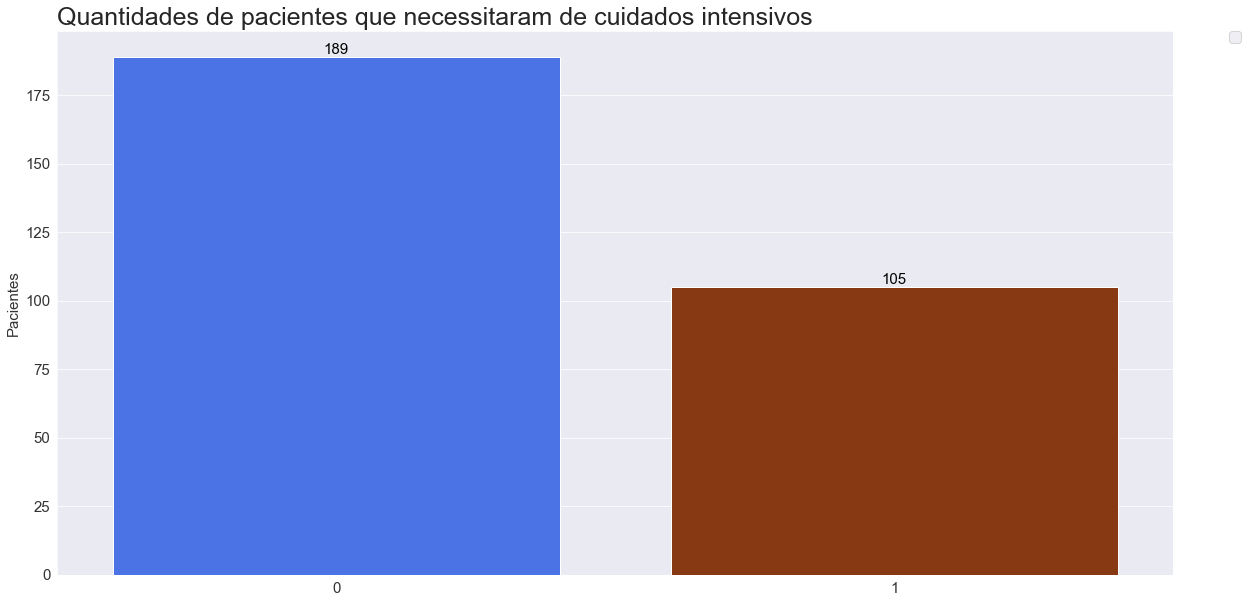

In [30]:
fig, ax = plt.subplots(figsize=(20,10)) 
sns.countplot(df['ICU'], ax=ax, palette=['#3366ff', '#993300'])
labs(title='Quantidades de pacientes que necessitaram de cuidados intensivos',
     xlabel='', ylabel='Pacientes',ax=ax)
annot_bar(prop=False, ax=ax)
handles, labels = ax.get_legend_handles_labels()
plt.legend(handles[0:2], ['Não foi para UTI', 'Foi para UTI'], bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., fontsize=15)
plt.show()

Observando a proporção da variável "ICU" fica claro que a maioria dos pacienetes presentes no dataset não precisaram de cuidados intensivos, fato este que apoia a realização de uma reamostragem, porém essa reamostragem será realizada e testada apenas quando formos comparar os modelos de machine learning no notebook [Predicoes]().

In [31]:
from numpy import any as numpy_any

In [32]:
numpy_any

<function numpy.any(a, axis=None, out=None, keepdims=<no value>)>

NameError: name 'central_trend' is not defined

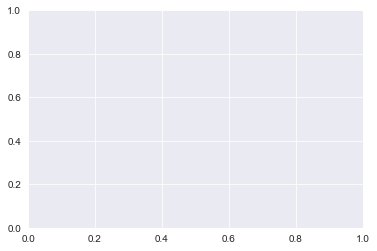

In [33]:
fig, ax= plt.subplots()
central_trend(df['RESPIRATORY_RATE_DIFF'], ax=ax, axis='y')

## Análise informações demográficas

De acordo com o Sirío-Libanês o dataset possui 3 variáveis demográficas, para identificá-las vamos observar novamente as primeiras linhas.

In [ ]:
df.head()

Fica claro que essas informações são representadas pelas colunas "AGE_ABOVE65", "AGE_PERCENTIL" e "GENDER", e dizem respeito a idade e genêro dos pacientes.

### Coluna "AGE_PERCENTIL"

A primeira coluna analisada será a coluna "AGE_PERCENTIL", que traz informações sobre a idade dos pacientes. No entanto temos um problema nessa variável, como ela representa o percentil da idade, ela foi representada através de caracteres. E pensando em modelos de machine learning precisamos transformá-la em uma variável inteira ou numérica, para decidir como realizar essa transformação vou analisar como a variável alvo "ICU" se comporta em relação a cada percentil de idade, para isso vou calcular qual a porcentagem de pacientes que foram para UTI para cada valor dessa coluna.

In [ ]:
# Agrupando o dataframe pela variável "AGE_PERCENTIL" e calculando a proporção de pessoas que foram para UTI 
percentil_prop = df.groupby('AGE_PERCENTIL')['ICU'].value_counts(normalize=True).reset_index(name='Prop')
percentil_prop

Com a tabela pronta podemos visualizar em um gráfico esse comportamento.

In [ ]:
fig, ax = plt.subplots(figsize=(20,10)) 

sns.barplot(data=percentil_prop, y='Prop', x='AGE_PERCENTIL', hue='ICU', ax=ax, palette=['#3366ff', '#993300'])
labs(title='Proporção de pacientes que foram para UTI por idade', subtitle='IDADE REPRESENTADA PELO PERCENTIL DA IDADE DO PACIENTE',
     xlabel='Percentil da idade', ylabel='Proporção',ax=ax)
handles, labels = ax.get_legend_handles_labels()
plt.legend(handles[0:2], ['Não foi para UTI', 'Foi para UTI'], bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., fontsize=15)
plt.ylim([0,1])
plt.show()

Observando o gráfico fica claro que dependendo da idade há uma proporção de pacientes diferentes que precisaram de cuidados intensivos. Além disso parece haver faixas etárias onde essa proporção sofre um aumento, por esta razão vou utilizar essa informação a fim de criar colunas categóricas binárias com base na faixa etária, com base no gráfico decidi criar as seguintes colunas:

|Coluna | Descrição|
|:-------------|:----------:|
|"AGE_UNDER_30th" | Pacientes com idade abaixo dos 30 anos
|"AGE_UNDER_50th" | Pacientes com idade abaixo dos 50 anos
|"AGE_ABOVE_50th"| Pacientes com idade acima dos 50 anos
|"AGE_ABOVE_80th"| Pacientes com idade acima dos 80 anos

In [ ]:
#Criando as colunas com base no percentil da idade
df['AGE_UNDER_30th'] = [1 if row['AGE_PERCENTIL'] in ['10th', '20th'] else 0 for _,row in df.iterrows()] 
df['AGE_UNDER_50th'] = [1 if row['AGE_PERCENTIL'] in ['10th', '20th','30th', '40th'] else 0 for _,row in df.iterrows()] 
df['AGE_ABOVE_50th'] = [1 if row['AGE_PERCENTIL'] in ['50th','60th', '70th','80th', '90th', 'Above 90th'] else 0 for _,row in df.iterrows()] 
df['AGE_ABOVE_80th'] = [1 if row['AGE_PERCENTIL'] in ['80th', '90th', 'Above 90th'] else 0 for _,row in df.iterrows()] 
# Eliminando a coluna "AGE_PERCENTIL" original
df.drop('AGE_PERCENTIL', axis=1, inplace=True)
df.head()

Agora com o problema da coluna Percentil resolvido temos 6 colunas demográficas, todas elas do tipo inteiro e categóricas.

### Teste de Chi Quadrado

Considerando que essas informações demográficas não possuem uma influência das demais variáveis, vou analisar cada uma individualmente analisando se elas possuem alguma relação de dependência com a variável alvo, ou seja, a variável "ICU". Para isso vou realizar um teste de Chi Quadrado de Pearson com significância de 5% para decidir se alguma dessas variáveis deve ser retirada.<br>
Este teste vai testar a seguinte hipótese:

### $H_0$ : Colunas demográficas são independentes em relação a variável alvo('ICU')
### $H_a$ : Colunas demográficas são dependentes em relação a variável alvo('ICU') 

![Região de Aceitação](https://caelum-online-public.s3.amazonaws.com/1229-estatistica-parte3/01/img017.png)

### Variáveis de idade

In [ ]:
ages = ['AGE_UNDER_30th','AGE_UNDER_50th','AGE_ABOVE_50th','AGE_ABOVE_80th','AGE_ABOVE65', 'ICU']
ages_melt = pd.melt(df[ages], id_vars='ICU')
ages_prop = ages_melt.groupby(['variable','value'])['ICU'].mean().reset_index(name='Prop')

In [ ]:
fig, ax = plt.subplots(figsize=(20,10)) 

sns.barplot(data=ages_prop, y='Prop', x='variable', hue='value', ax=ax, palette='muted')
labs(title='Proporção de pacientes que foram para UTI dentre os grupos de doenças', 
     subtitle='PROPORÇÃO CALCULADA DE PACIENTES QUE FORAM PARA UTI DADO QUE APRESENTOU DETERMINADO GRUPO DE DOENÇA',
     xlabel='Variável', ylabel='Proporção',ax=ax)
handles, labels = ax.get_legend_handles_labels()
plt.legend(handles[0:2], ['0','1'], bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., fontsize=15)
plt.xticks(range(5),labels=ages_prop['variable'].str.split(r'_| ').str.join('\n').unique())
annot_bar(ages_prop, ax)
plt.ylim([0,1])
plt.show()

In [ ]:
p_values = compute_chi2(df[ages].drop('ICU', axis=1), df['ICU'])
for col, p_value in p_values.items():
    print(f'Considerando a hipótese nula de que a coluna {col} é independente da variável alvo "ICU" obteve-se um p valor igual a {p_value}')

Analisando o p valor das colunas relacionadas as idades dos pacientes no teste de Chi-Quadrado da hipótese nula das variáveis serem independentes do paciente ir para UTI temos evidências para **rejeitar a hipótese nula** e por esta razão estas variávies serão mantidas no dataframe.

### Variável de genêro

In [ ]:
gender_melt  = pd.melt(df[['GENDER', 'ICU']], id_vars='ICU')
gender_prop = gender_melt.groupby(['variable','value'])['ICU'].mean().reset_index(name='Prop')

In [ ]:
fig, ax = plt.subplots(figsize=(12,8)) 

sns.barplot(data=gender_prop, y='Prop', x='variable', hue='value', ax=ax, palette=['#ffcc00','#0066ff'])
labs(title='Proporção de pacientes que foram para UTI dentre os gêneros', 
     subtitle='PROPORÇÃO CALCULADA DE PACIENTES QUE FORAM PARA UTI DADO O GENÊRO',
     xlabel='Variável', ylabel='Proporção',ax=ax)
handles, labels = ax.get_legend_handles_labels()
plt.legend(handles[0:2], ['0','1'], bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., fontsize=15)
annot_bar(gender_prop, ax)
plt.ylim([0,1])
plt.show()

In [ ]:
p_values = compute_chi2(df[['GENDER']], df['ICU'])
for col, p_value in p_values.items():
    print(f'Considerando a hipótese nula de que a coluna {col} é independente da variável alvo "ICU" obteve-se um p valor igual a {p_value}')

Analisando o p valor da coluna de genêro no teste de chi2 da hipótese nula da variável ser independente do paciente ir para UTI **não temos evidências para rejeitar a hipótese nula** e por esta razão vou eliminar a coluna "GENDER" do dataframe.

In [ ]:
#Eliminando a coluna "GENDER"
df = df.drop('GENDER', axis=1)

### Colunas relacionadas as doenças dos pacientes

Além das 

In [ ]:
diseases = ['DISEASE GROUPING 1','DISEASE GROUPING 2','DISEASE GROUPING 3','DISEASE GROUPING 4',\
            'DISEASE GROUPING 5','DISEASE GROUPING 6','HTN','IMMUNOCOMPROMISED','OTHER', 'ICU']

In [ ]:
diseases_melt  = pd.melt(df[diseases], id_vars='ICU')
diseases_prop = diseases_melt.groupby(['variable','value'])['ICU'].mean().reset_index(name='Prop')

In [ ]:
fig, ax = plt.subplots(figsize=(20,10)) 

sns.barplot(data=diseases_prop, y='Prop', x='variable', hue='value', ax=ax, palette='muted')
labs(title='Proporção de pacientes que foram para UTI dentre os grupos de doenças', 
     subtitle='PROPORÇÃO CALCULADA DE PACIENTES QUE FORAM PARA UTI DADO QUE APRESENTOU DETERMINADO GRUPO DE DOENÇA',
     xlabel='Variável', ylabel='Proporção',ax=ax)
handles, labels = ax.get_legend_handles_labels()
plt.legend(handles[0:2], ['0','1'], bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., fontsize=15)
plt.xticks(range(9),labels=diseases_prop['variable'].str.split(r'_| ').str.join('\n').unique())
annot_bar(diseases_prop, ax)
plt.ylim([0,1])
plt.show()

# Análise Variáveis Numéricas

## Análise de correção entre as variáveis

In [ ]:
fig,ax = plt.subplots(figsize=(35, 30))
cor = df.corr().abs()
mask = np.triu(np.ones_like(cor, dtype=bool))
sns.heatmap(cor,
            cmap='Reds',
            mask=mask,
            ax=ax)
labs(title='Correlação entre variáveis contínuas do conjunto de dados', ax=ax)
plt.show()

### Teste de correlação

In [ ]:
cols_drop_high_corr = compute_high_corr(df)
print(cols_drop_high_corr)

In [ ]:
df = df.drop(cols_drop_high_corr, axis=1)

## Análise da Variância das features

In [ ]:
np.random.seed(SEED)
cont = df.select_dtypes('float64')
sample = cont[np.random.choice(cont.columns, size=15, replace=False)]
sample_cont = pd.concat([sample, df['ICU']],axis=1) 
cont_melt = pd.melt(sample_cont, id_vars='ICU')

In [ ]:
fig, ax = plt.subplots(figsize=(20,10))

sns.boxplot(x='variable', y='value', hue='ICU',
            data=cont_melt, palette=['#3366ff', '#993300'], 
            ax=ax, showfliers=False)
sns.stripplot(x='variable', y='value', hue='ICU',
              data=cont_melt, palette=['#3366ff', '#993300'],
              ax=ax, dodge=True)
labs(title='Boxplots de 15 colunas contínuas aleatórias', 
     xlabel='Coluna', 
     ylabel='Valor', 
     subtitle='COLUNAS REFERENTES AOS DADOS MÉDICOS DE EXAMES E SINAIS VITAIS', ax=ax)
plt.xticks(range(15),labels=cont_melt['variable'].str.split('_').str.join('\n').unique(), rotation=35)
handles, labels = ax.get_legend_handles_labels()
plt.legend(handles[0:2], ['Não foi para UTI', 'Foi para UTI'], bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., fontsize=15)
plt.show()

In [ ]:
var = df.select_dtypes('float64').var()
var.sort_values().head()

In [ ]:
cols_0_var = [col for col in var.index if var[col] == 0]
print(cols_0_var)

In [ ]:
df = df.drop(cols_0_var,axis=1)

In [ ]:
df

### Teste de variância e médias iguais

In [ ]:
df.to_csv('../dados/dados_preprocessados/Kaggle_Sirio_Libanes_ICU_Prediction.csv', index=False)